# Homework 7

## References

+ Lectures 19-20 (inclusive).


## Instructions

+ Type your name and email in the "Student details" section below.
+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you can either:
    
    - Type the answer using the built-in latex capabilities. In this case, simply export the notebook as a pdf and upload it on gradescope; or
    - You can print the notebook (after you are done with all the code), write your answers by hand, scan, turn your response to a single pdf, and upload on gradescope.

+ The total homework points are 100. Please note that the problems are not weighed equally.

**Note**: Please match all the pages corresponding to each of the questions when you submit on gradescope. 

## Student details

+ **First Name:** Alex
+ **Last Name:** Shank
+ **Email:** shank14@purdue.edu

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')
import scipy.stats as st
# A helper function for downloading files
import requests
import os
def download(url, local_filename=None):
    """
    Downloads the file in the ``url`` and saves it in the current working directory.
    """
    data = requests.get(url)
    if local_filename is None:
        local_filename = os.path.basename(url)
    with open(local_filename, 'wb') as fd:
        fd.write(data.content)

# Problem 1 - Filtering of an Oscillator with Damping

Assume that you are dealing with a one-degree-of-freedom system which follows the equation:
$$
\ddot{x} + 2\zeta \omega_0 \dot{x} + \omega^2_0 x = u_0 \cos(\omega t),
$$
where $x = x(t)$ is the generalized coordinate of the oscillator at time $t$, and the parameters $\zeta$, $\omega_0$, $u_0$, and $\omega$ are known to you (we will give them specific values later).
Furthermore, assume that you are making noisy observations of the **absolute acceleration** at discrete timesteps $\Delta t$ (also known):
$$
y_j = \ddot{x}(j\Delta t)-u_0 \cos(\omega t)+w_j,
$$
for $j=1,\dots,n$, where $w_j \sim N(0, \sigma^2)$ with $\sigma^2$ also known.
Finally, assume that the initial conditions for the position and the velocity (you need both to get a unique solution) are given by:
$$
x_0 = x(0) \sim N(0, \sigma_x^2),
$$
and
$$
v_0 = \dot{x}(0) \sim N(0, \sigma_v^2).
$$
Of course assume that $\sigma_x^2$ and $\sigma_v^2$ are specific numbers that we are going to specify below.

Before I we go over the questions, let's write code that generates the true trajectory of the system at some random initial conditions as well as some observations.
We will use the code to generate a synthetic dataset with known ground truth which you will use in your filtering analysis.

The first step we need to do, is to turn the problem into a first order differential equation.
This is trivial.
We set:
$$
\mathbf{x} = 
\begin{bmatrix}
x\\
\dot{x}
\end{bmatrix}.
$$
Assuming $\mathbf{x} = (x_1,x_2)$, then the dynamics are described by:
$$
\dot{\mathbf{x}} = 
\begin{bmatrix}
\dot{x}\\
\ddot{x}
\end{bmatrix}
= 
\begin{bmatrix}
x_2\\
-2\zeta \omega_0 \dot{x} - \omega^2_0 x + u_0 \cos(\omega t)
\end{bmatrix}
=
\begin{bmatrix}
x_2\\
-2\zeta \omega_0 x_2 - \omega^2_0 x_1 + u_0 \cos(\omega t)
\end{bmatrix}
$$
The initial conditions are of course just:
$$
\mathbf{x}_0 =
\begin{bmatrix}
x_0\\
v_0
\end{bmatrix}.
$$

This first order system can solved using [scipy.integrate.solve_ivp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp).
Here is how:

In [2]:
from scipy.integrate import solve_ivp

# You need to define the right hand side of the equation
def rhs(t, x, omega0, zeta, u0, omega):
    """
    Returns the right hand side of the dynamical system.
    
    Arguments
    t       -    Time
    x       -    The state
    omega0  -    Natural frequency
    zeta    -    Dumping factor (0<=zeta)
    u0      -    External force amplitude
    omega   -    Excitation frequency
    """
    res = np.ndarray((2,))
    res[0] = x[1]
    res[1] = -2.0 * zeta * omega0 * x[1] - omega0 ** 2 * x[0] + u0 * np.cos(omega * t)
    return res

And here is how you solve it for given initial conditions and parameters:

In [3]:
# Initial conditions
x0 = np.array([0.0, 1.0])
# Natural frequency
omega0 = 2.0
# Damping factor
zeta = 0.4
# External forcing amplitude
u0 = 0.5
# Excitation frequency
omega = 2.1
# Timestep
dt = 0.1
# The final time
final_time = 10.0
# The number of timesteps to get the final time
n_steps = int(final_time / dt)
# The times on which you want the solution
t_eval = np.linspace(0, final_time, n_steps)
# The solution
sol = solve_ivp(rhs, (0, final_time), x0, t_eval=t_eval, args=(omega0, zeta, u0, omega))

The solution is stored here:

In [4]:
sol.y.shape

(2, 100)

You see that the shape is ``number of states x number of time steps``.
Let's visualize the trajectory separating position and velocity:

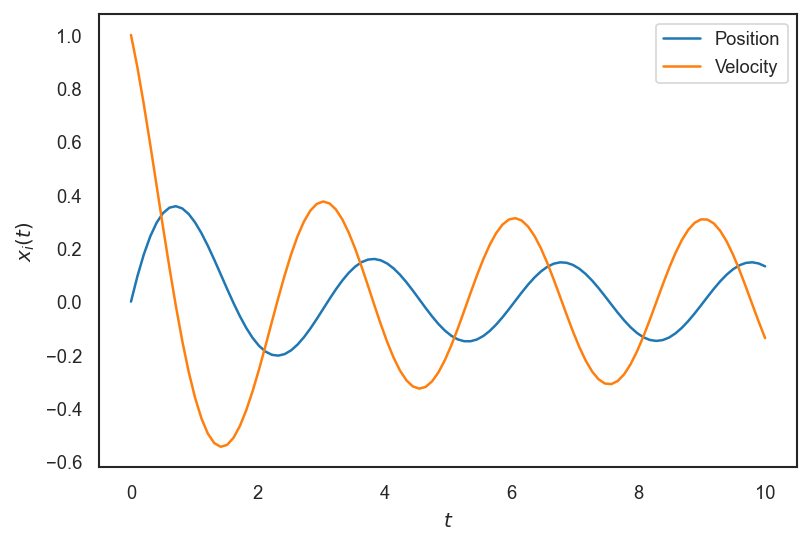

In [5]:
fig, ax = plt.subplots(dpi=150)
ax.plot(t_eval, sol.y[0, :], label='Position')
ax.plot(t_eval, sol.y[1, :], label='Velocity')
ax.set_xlabel('$t$')
ax.set_ylabel('$x_i(t)$')
plt.legend(loc='best');

Let's now generate some synthetic observations of the acceleration with some given Gaussian noise.
To get the true acceleration you can do this:

In [6]:
true_acc = np.array([rhs(t, x, omega0, zeta, u0, omega)[1] for (t, x) in zip(t_eval, sol.y.T)])

And now I am going to add some Gaussian noise to it:

In [7]:
# The measurement standard deviation
sigma_r = 0.2
observations = true_acc + sigma_r * np.random.randn(true_acc.shape[0])

And here is how the noisy observations of the acceleration look like compared to the true acceleration value:

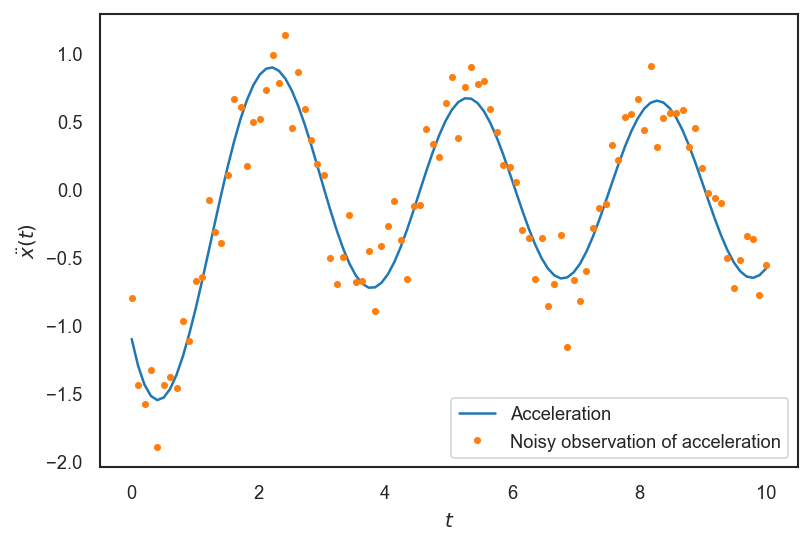

In [8]:
fig, ax = plt.subplots(dpi=150)
ax.plot(t_eval, true_acc, label='Acceleration')
ax.plot(t_eval, observations, '.', label='Noisy observation of acceleration')
ax.set_xlabel('$t$')
ax.set_ylabel('$\ddot{x}(t)$')
plt.legend(loc='best');

Okay. Now imagine that you only see the noisy observations of the acceleration.
The filtering goal is to recover the state of the underlying system (as well as its acceleration).
I am going to guide you through the steps you need to follow.

## Part A - Discretize time (Transitions)

Use the Euler time discretization scheme to turn the continuous dynamical system into a discrete time dynamical system like this:
$$
\mathbf{x}_{j+1} = \mathbf{A}\mathbf{x}_j + Bu_j + \mathbf{z}_j,
$$
where
$$
\mathbf{x}_j = \mathbf{x}(j\Delta t),
$$
$$
u_j = u(j\Delta t),
$$
and $\mathbf{z}_j$ is properly chosen process noise term.
You should derive and provide mathematical exprssions for the following:
+ The $2 \times 2$ transition matrix $\mathbf{A}$.
+ The $2 \times 1$ control "matrix" $B$.
+ The process covariance $\mathbf{Q}$. For the process covariance, you may choose your own values by hand.

**Answer:**
The handwritten derivations shown below conclude that...
<br><br>
$$
\mathbf{A} = 
\begin{bmatrix}
1 & \Delta t\\
-2\Delta t \omega^2_0 & -2 \zeta \omega_0 \Delta t + 1
\end{bmatrix}
$$
<br><br>
$$
\mathbf{B} = 
\begin{bmatrix}
0\\
u_0 \Delta t \cos(\omega j \Delta t)
\end{bmatrix}
$$
<center><b>or to match our form more closely...</b></center>
$$
\mathbf{B} = 
\begin{bmatrix}
0 & 0\\
0 & \Delta t \cos(\omega j \Delta t)
\end{bmatrix}
\mathbf{U_j} = 
\begin{bmatrix}
0\\
u_0
\end{bmatrix}
$$
<br><br>
$$
\mathbf{Q} = 
\begin{bmatrix}
\sigma_q^2 & 0\\
0 & \sigma_q^2
\end{bmatrix}
$$
<br>
<center>
where
$\sigma_q^2 = 0.01$ arbitrarily</center>

**Note** I forgot to multiply $Z_j$ by $\Delta tt$ below, but it should be.
<br><br>
Derivation below
![Part A_1](part_A_1.jpeg)
![Part A_2](part_A_2.jpeg)

## Part B - Discretize time (Emissions)

Establish the map that takes you from the states to the accelerations at each timestep.
That is, specify:
$$
y_j = \mathbf{C}\mathbf{x}_j + w_j,
$$
where
$$
y_j = \ddot{x}(j\Delta t)-u_0 \cos(\omega t)+w_j,
$$
and $w_j$ is a measurement noise.
You should derive and provide mathematical expressions for the following:
+ The $1 \times 2$ emission matrix $\mathbf{C}$.
+ The $1 \times 1$ covariance "matrix" $R$ of the measurement noise.

**Answer:**
The handwritten derivations shown below conclude that...
<br><br>
$$
\mathbf{C} = 
\begin{bmatrix}
-\omega^2_0 & -2 \zeta \omega_0
\end{bmatrix}
$$
<br><br>
$$
\mathbf{R} = 
\begin{bmatrix}
\sigma_r^2
\end{bmatrix}
$$
<br>
<center>
where
$\sigma_r^2 = 0.2$ as used in given synthetic dataset</center>

Derivation below
![Part B](part_B.jpeg)

## Part C - Apply the Kalman filter

Use ``FilterPy`` (see the hands-on activity of Lecture 20) to infer the unobserved states given the noisy observations of the accelerations.
Plot time-evolving 95% credible intervals for the position and the velocity along with the true unobserved values of these quantities (in two separate plots).

In [9]:
epsilon = 1e-2

# The standard deviation for the process noise for velocity
sigma_q = 1e-2
# The standard deviation for the measurement noise for position
sigma_r = 0.2

# INITIAL CONDITIONS
# initial mean
mu0 = np.zeros((2,))
# initial covariance
V0 = np.eye(2)

# TRANSITION MATRIX
A = np.array([[1.0          , dt],
              [-dt*omega0**2, -2.0*zeta*omega0*dt + 1]])
# CONTROL MATRIX
B = np.array([[0.0],
              [u0*dt]])
# PROCESS COVARIANCE
Q = np.array([epsilon, sigma_q]) * np.eye(2) * dt
# EMISSION MATRIX
C = np.array([[-omega0**2, -2.0*zeta*omega0]])
# MEASUREMENT COVARIANCE
R = np.array([sigma_r ** 2]).reshape(1,1)

In [10]:
from filterpy.kalman import KalmanFilter
kf = KalmanFilter(dim_x=2, dim_z=1)
us = np.array([np.cos(omega * j *dt) for j in range(n_steps)]).reshape(100,1)

In [11]:
# check all our dimensions look ok
print(V0.shape)   # 2,2
print(A.shape)    # 2,2
print(B.shape)    # 2,1
print(us.shape)   # 100,1
print(Q.shape)    # 2,2
print(C.shape)    # 1,2
print(R.shape)    # 1,1

# translate our notation to the python library's
kf.x = mu0
kf.P = V0
kf.Q = Q
kf.R = R
kf.H = C
kf.F = A
kf.B = B

(2, 2)
(2, 2)
(2, 1)
(100, 1)
(2, 2)
(1, 2)
(1, 1)


In [12]:
# reset just to be safe
kf.x = mu0
kf.P = V0

res = kf.batch_filter(observations, us=us)
means = res[0]
covs = res[1]

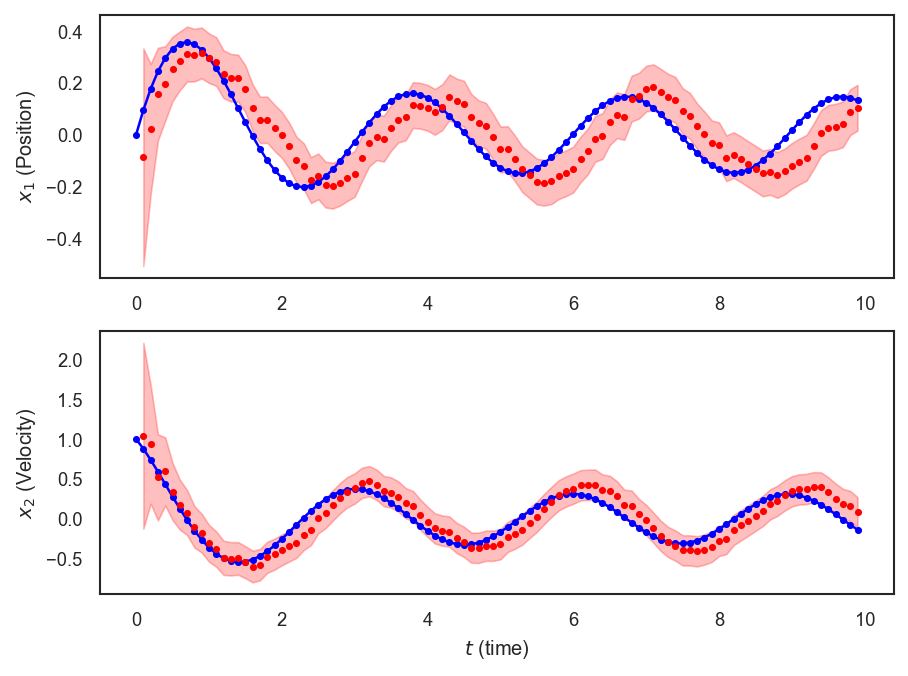

In [13]:
y_labels = ['$x_1$ (Position)', '$x_2$ (Velocity)']

res_x = 1024
res_y = 768
dpi = 150
w_in = res_x / dpi
h_in = res_y / dpi
fig, ax = plt.subplots(2, 1, dpi=dpi)
fig.set_size_inches(w_in, h_in)

times = dt * np.arange(n_steps + 1)

for j in range(2):
    ax[j].set_ylabel(y_labels[j])
ax[-1].set_xlabel('$t$ (time)')

for j in range(2):
    ax[j].plot(times[0:n_steps], sol.y[j, :].T, 'b.-')
    ax[j].plot(times[1:n_steps], means[1:n_steps, j], 'r.')
    ax[j].fill_between(times[1:n_steps],
                            means[1:n_steps, j].flatten() - 2.0 * np.sqrt(covs[1:n_steps, j, j].reshape(99,)),
                            means[1:n_steps, j].flatten() + 2.0 * np.sqrt(covs[1:n_steps, j, j].reshape(99,)),
                            color='red', alpha=0.25)                


## Part D - Quantify and visualize your uncertainty about the true acceleration value

Use standard uncertainty propagation techniques to quantify your epistemic uncertainty about the true acceleration value.
You will have to use the inferred states of the system and the dynamical model.
This can be done either analytically or by Monte Carlo. It's your choice.
In any case, plot time-evolving 95% credible intervals for the acceleration (epistemic only) along with the true unobserved values and the noisy measurements.

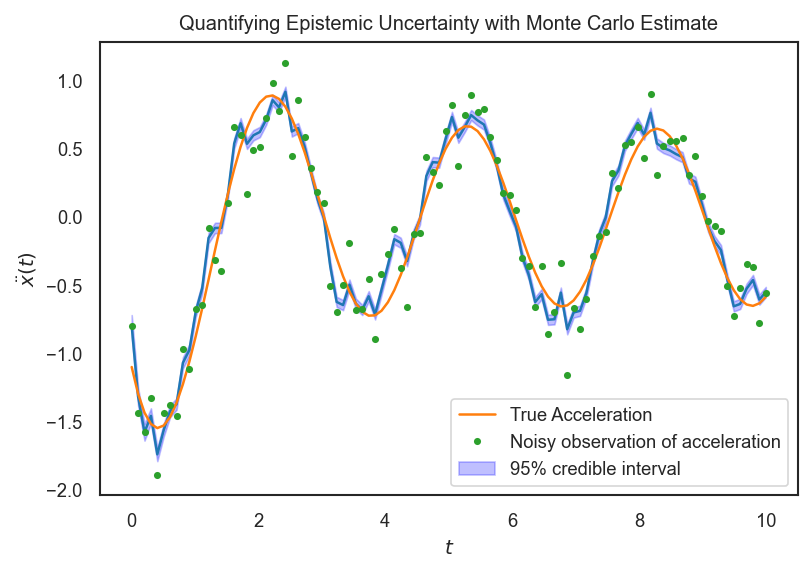

In [14]:
y_means = np.dot(means, C.T)[:,0]
y_vars = np.einsum('ij,kjl,il', C, covs, C)

# plot some positions and the average at each timestep
fig1, ax1 = plt.subplots(dpi=150)
ax1.plot(t_eval, y_means)
ax1.fill_between(t_eval, y_means - 2.0 * y_vars, y_means + 2.0 * y_vars, color='blue', alpha=0.25, label='95% credible interval')
ax1.plot(t_eval, true_acc, label='True Acceleration')
ax1.plot(t_eval, observations, '.', label='Noisy observation of acceleration')
ax1.set_xlabel('$t$')
ax1.set_ylabel('$\ddot{x}(t)$')
ax1.set_title('Quantifying Epistemic Uncertainty with Monte Carlo Estimate')
plt.legend(loc='best');